# Gold Price Prediction Modeling Phase

This notebook builds an LSTM model using our preprocessed datasets to predict the next day's high / low.

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import root_mean_squared_error

## RFE dataset implementation

In [44]:
# Load the dataset
#df_rfe = pd.read_csv("../data/processed/dataset_RFE.csv", parse_dates=["date"])
#df_rfe = pd.read_csv("../data/processed/dataset_full.csv", parse_dates=["date"])
df_rfe = pd.read_csv("../data/processed/dataset_RF.csv", parse_dates=["date"])
#df_rfe = pd.read_csv("../data/processed/dataset_MI.csv", parse_dates=["date"])
df_rfe = df_rfe.sort_values("date")
df_rfe.tail()

,date,oil_close,volume,dxy_close,rsi_14,ema_200,next_open,high,low,target
2294,2025-02-20,0.455510,-0.157693,1.519260,0.987063,2.716108,3.105136,3.107683,3.106356,-21.500000
2295,2025-02-21,0.345289,-0.160621,1.571142,1.104501,2.726444,3.091162,3.069191,3.089340,24.799805
2296,2025-02-24,0.364107,-0.165898,1.569220,1.038398,2.736968,3.104891,3.112798,3.128305,-48.699951
2297,2025-02-25,0.269478,-0.116905,1.513496,0.318775,2.746165,3.043111,3.076987,3.022013,3.500000
2298,2025-02-26,0.243133,-0.110232,1.534633,0.268888,2.755618,3.055369,3.013159,3.078735,-48.100098


## Prepare Data for LSTM

We will create sequences of a fixed window size from our dataset. Each sequence will contain past values for our features, and the corresponding target will be the next day's value.

In [ ]:
def create_sequences(data, features, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[features].iloc[i:i+window_size].values)
        y.append(data[target].iloc[i+window_size])
    return np.array(X), np.array(y)

# Define feature columns (exclude 'Date' and 'target')
features = df_rfe.columns.difference(["date", "target"]).tolist()
target = "target"

# Set the window size (20 days)
window_size = 20
X, y = create_sequences(df_rfe, features, target, window_size)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2279, 20, 8)
y shape: (2279,)


## Train-Test Split

We split the sequences into training and testing sets using an 80/20 split (keeping the time order).

In [50]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 1823
Testing samples: 456


## Build and Train the LSTM Model

In [51]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window_size, len(feature_cols))),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Set up early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop])

Epoch 1/50
52/52 [==============================] - 1s 11ms/step - loss: 287.9736 - val_loss: 337.3994
Epoch 2/50
52/52 [==============================] - 0s 6ms/step - loss: 287.5929 - val_loss: 337.0128
Epoch 3/50
52/52 [==============================] - 0s 5ms/step - loss: 287.4460 - val_loss: 336.6068
Epoch 4/50
52/52 [==============================] - 0s 5ms/step - loss: 287.3278 - val_loss: 336.0064
Epoch 5/50
52/52 [==============================] - 0s 5ms/step - loss: 287.0492 - val_loss: 336.6001
Epoch 6/50
52/52 [==============================] - 0s 5ms/step - loss: 287.4964 - val_loss: 336.1830
Epoch 7/50
52/52 [==============================] - 0s 5ms/step - loss: 286.1373 - val_loss: 339.4734
Epoch 8/50
52/52 [==============================] - 0s 5ms/step - loss: 286.0454 - val_loss: 337.2283
Epoch 9/50
52/52 [==============================] - 0s 5ms/step - loss: 285.5553 - val_loss: 339.7414
Epoch 10/50
52/52 [==============================] - 0s 5ms/step - loss: 285.4499

## Evaluate the Model

15/15 [==============================] - 0s 1ms/step
Test RMSE: 22.096539412541592


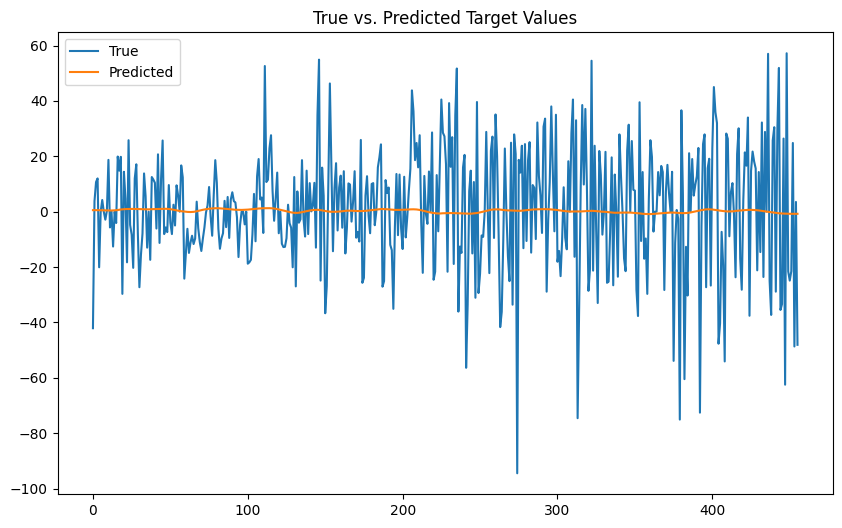

In [52]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = root_mean_squared_error(y_test, y_pred)
print("Test RMSE:", rmse)

# Plot true vs. predicted target values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.title("True vs. Predicted Target Values")
plt.legend()
plt.show()